In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
from scipy.special import softmax

from timeit import default_timer as timer
import random
import cv2

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr

from tf_keras_vis.utils.callbacks import Print

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from tf_keras_vis.activation_maximization import ActivationMaximization


import json
import pickle
import os
import sys
sys.path.append("../python/")
from helpers import *
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [2]:
# Globals
NUM_CHANNELS = 1
RESOLUTION_LIST = [128] # 64, 128] #, 224, 384]
SCENARIO_LIST = ["PrPo_Im"] #, "Pr_Im", "Pr_PoIm", "Pr_Po_Im"]
NUM_EPOCHS = 20
SAVED_MODEL_DIR = '../../results/models/'
MODEL_PERFORMANCE_METRICS_DIR = '../../results/model-performance/'
FULL_MODEL_PATH = '../../results/models/opt-cnn-PrPo_Im-128-px/model'

In [3]:
## these can also be globally set.
trial_seed = 1
class_labels = getClassLabels("PrPo_Im")
image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)
training_images, validation_images, training_labels, validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[128]["PrPo_Im"]]), 
                np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), stratify= np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), test_size=.2, random_state = trial_seed)

In [4]:
GLOBAL_MODEL = models.load_model(FULL_MODEL_PATH)

Obtaining the class activation maps (CAM) and gradients from the three visualization techniques.

In [5]:
def grad_cam(index): 
    #assert validation_labels[index].mean(axis=0)[0] == 0 ## This will throw an error for an image in the 1 class. Elaborate on it or comment out.
    cam_img = index # class activation map corresponds to the specified image index 
    probPrediction = [] # store probability of prediction by the CNN
    predictedClass = [] # store CNN-predicted class 
    print("Observed image class: ", class_labels[np.argmax(validation_labels[cam_img])])
    m = GLOBAL_MODEL
    def loss(output):
        """Returns score corresponding to class of given image index"""                                       
        print("Loss output: ", output) ##
        loss_list = [output[i][j] for i, j in enumerate([np.argmax(j) for j in validation_labels[cam_img] ])]
        print(loss_list)
        probPrediction.append(str([np.round(max(softmax(loss)), 2) for loss in output.numpy()])[1:-1])
        predictedClass.append(class_labels[np.argmax([softmax(loss) for loss in output.numpy()])])
        print('Probability of prediction: ', probPrediction)
        print('Predicted class: ', predictedClass)
        print([softmax(loss) for loss in output.numpy()])
        return loss_list

    print('Class labels: ', class_labels)
    
    # Model_modifier function required for gradcam
    def model_modifier(model):
        """Remove softmax activation of last layer in model"""
        model.layers[-1].activation = tf.keras.activations.linear # Assign linear activation function (pass-through) to the activation of layer at -1
        return model
    
    gradcam_image = validation_images[cam_img]
    gradcam = Gradcam(m, model_modifier = model_modifier)
    cam = gradcam(loss, gradcam_image, penultimate_layer = -1) # Penultimate layer is a fully-connected hidden layer. 
    cam = normalize(cam)
    cam = np.squeeze(cam) # replace np.squeeze 
    print("Shape of heatmap matrix:", cam.shape )
    return cam, gradcam_image, probPrediction, predictedClass

In [6]:
def guided_backprop(index, activation_layer):
    # Reference: https://colab.research.google.com/drive/17tAC7xx2IJxjK700bdaLatTVeDA02GJn#scrollTo=jgTRCYgX4oz-&line=1&uniqifier=1  
    backprop_image = validation_images[index]    
    @tf.custom_gradient
    def guidedRelu(x):
        def grad(dy):
            return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy
        return tf.nn.relu(x), grad

    model = models.load_model(FULL_MODEL_PATH) # set model inside the function
    modified_model = models.Model(
        inputs = [model.inputs],
        outputs = [model.get_layer(activation_layer).output]
    )
    layer_dict = [layer for layer in modified_model.layers[1:] if hasattr(layer,'activation')]
    for layer in layer_dict:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guidedRelu

    with tf.GradientTape() as tape:
        inputs = tf.cast(backprop_image, tf.float32)
        tape.watch(inputs)
        outputs = modified_model(inputs)

    grads = tape.gradient(outputs,inputs)[0]
    return grads  

In [7]:
def guided_gradcam(index, normalize=False):
    # element-wise multiplication in Python
    # https://stackoverflow.com/questions/40034993/how-to-get-element-wise-matrix-multiplication-hadamard-product-in-numpy
    gbp = guided_backprop([index], 'conv2d_4')
    if normalize:
        gbp = deprocess_image(np.array(np.squeeze(gbp)))
    else:
        gbp = np.squeeze(gbp)
        
    ggcam = grad_cam([index])[0] * gbp
    
    print('Shape of GGCAM: ', ggcam.shape)
    return ggcam

Visually rendering the outputs of the three functions and the original image from the validation set.

In [8]:
def renderOriginal(index, save=False, grid=False, c_map='gist_gray'):
    '''Plot the original image found in the validation set.'''
    originals_dir = '../../figures/plottingOriginals/'
    print('Observation: ',class_labels[np.argmax(validation_labels[index])])
    if grid==False:
        standardizePlot(index, originals_dir, 'Original Image (validation) in '+ c_map)
        plt.imshow(np.squeeze(validation_images[index]), cmap=c_map)
    else:
        plt.axis('off')
        plt.tight_layout()
        plt.imshow(np.squeeze(validation_images[index]), cmap=c_map)
    if save:
        plt.savefig(originals_dir+'original-'+str(index)+'-'+c_map+'.jpg')
    return validation_images[index]

Observation:  Improbable


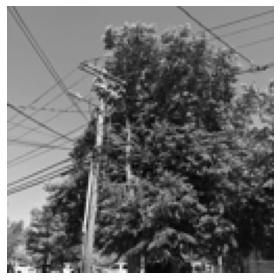

In [9]:
ro = renderOriginal(18, False, True)

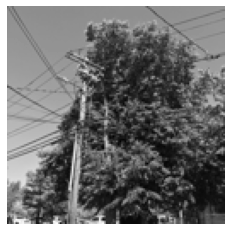

In [10]:
plt.axis('off')
plt.imshow(np.squeeze(validation_images[18]), cmap='gist_gray')

In [11]:
def renderGradCam(index, save=False, grid=False, c_map='gist_gray'):
    '''Visualizing gradient-weighted class activation maps as an overlay (heatmap) to the original image.'''
    gradcam_dir = '../../figures/plottingGradCam/'
    gcam = grad_cam([index])
    class_labels = getClassLabels("PrPo_Im")
    
    if grid==False:
        plt.figure(figsize=(5, 5))
        plt.suptitle('Grad-CAM Index '+str(index)[1:-1]+'\n')
        plt.title('Observed class: '+class_labels[np.argmax(validation_labels[index])], y=-0.08)
        plt.text(-0.7,-0.05, "Probability of prediction: "+ str("{:.0%}".format(float(str(gcam[2])[2:-2])))+'\n', size=12)
        plt.text(-0.7,-0.35, 'Predicted class: '+ str(gcam[3])[2:-2], size=12)
        plt.axis('off')
        plt.tight_layout()
        heatmap = np.uint8(cm.jet(gcam[0])[..., :3] * 255)
        plt.imshow(np.squeeze(gcam[1]), cmap=c_map) # remove axes of length one from gradcam_images
        plt.imshow(heatmap, cmap='gist_gray', alpha=0.5) # overlay
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
    else:
        plt.axis('off')
        plt.tight_layout()
        heatmap = np.uint8(cm.jet(gcam[0])[..., :3] * 255)
        plt.imshow(np.squeeze(gcam[1]), cmap=c_map)
        plt.imshow(heatmap, cmap='gist_gray', alpha=0.5)
    
    if save:
        if not os.path.exists(gradcam_dir):
            os.makedirs(gradcam_dir)
        plt.savefig(gradcam_dir+"gradcam-"+str(index)[1:-1]+".png")
#     plt.show()
    return (heatmap)

Observed image class:  Improbable
Class labels:  ['Probable/Possible', 'Improbable']
Loss output:  tf.Tensor([[-2.5035484  3.0303414]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=3.0303414>]
Probability of prediction:  ['1.0']
Predicted class:  ['Improbable']
[array([0.00393505, 0.99606496], dtype=float32)]
Shape of heatmap matrix: (128, 128)


array([[[  2, 232, 244],
        [  5, 236, 241],
        [ 15, 248, 231],
        ...,
        [  0, 208, 255],
        [  0, 192, 255],
        [  0, 188, 255]],

       [[  2, 232, 244],
        [  5, 236, 241],
        [ 18, 252, 228],
        ...,
        [  0, 212, 255],
        [  0, 196, 255],
        [  0, 192, 255]],

       [[  2, 232, 244],
        [  8, 240, 237],
        [ 18, 252, 228],
        ...,
        [  0, 224, 250],
        [  0, 212, 255],
        [  0, 204, 255]],

       ...,

       [[  0, 180, 255],
        [  0, 184, 255],
        [  0, 196, 255],
        ...,
        [  0, 184, 255],
        [  0, 180, 255],
        [  0, 176, 255]],

       [[  0, 160, 255],
        [  0, 168, 255],
        [  0, 180, 255],
        ...,
        [  0, 192, 255],
        [  0, 188, 255],
        [  0, 184, 255]],

       [[  0, 156, 255],
        [  0, 160, 255],
        [  0, 176, 255],
        ...,
        [  0, 196, 255],
        [  0, 188, 255],
        [  0, 188, 255]]

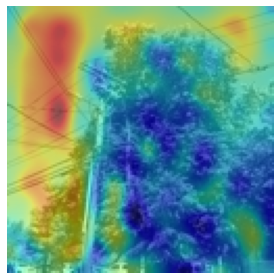

In [12]:
renderGradCam(18, False, True)

In [13]:
def renderGBP(index, normalize=False, save=False, grid=False, c_map='gist_gray'):
    '''Visualizing Guided Backpropagation with an option to use normalized gradients.'''
    gbp = guided_backprop([index], 'conv2d_4')
    gbp_dir = '../../figures/plottingBackProp/'
    save_name = ''
    
    print(np.squeeze(gbp).shape)
    if grid==False:
        standardizePlot(index, gbp_dir, 'Guided Backpropagation')    

        if normalize:
            save_name = gbp_dir+"guided_backprop-"+str(index)+'-normalized-'+c_map+".png"
            normalize_gbp = deprocess_image(np.array(np.squeeze(gbp)))
            plt.imshow(normalize_gbp, cmap = c_map)
        else:
            save_name = gbp_dir+"guided_backprop-"+str(index)+'-'+c_map+".png"
            plt.imshow(np.squeeze(gbp), cmap=c_map)
    else:
        plt.axis('off')
        plt.tight_layout()
        plt.imshow(np.squeeze(gbp), cmap=c_map)
    
    if save:
        plt.savefig(save_name)
    return (gbp)

(128, 128)


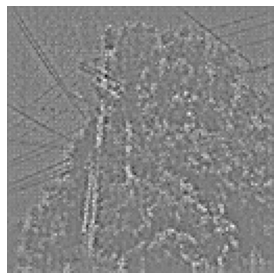

In [25]:
gbp1 = renderGBP(18, True, False, True)

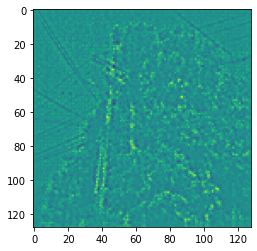

In [15]:
plt.imshow(np.squeeze(gbp1))

In [16]:
def renderGGCAM(index, normalize=False, save=False, grid = False, c_map='gist_gray'):
    '''Visualizing Guided Grad-CAM output with an option to use normalized guided backpropagation gradients.'''
    ggcam_dir = '../../figures/plottingGuided-GradCam/'
    plot_name = ''
    ggcam = guided_gradcam(index, True)
    
    if grid==False:
        if normalize:
            plot_name = "guided-gradcam-"+str(index)+'-'+c_map+'-normalized.png'
            print('Using normalized GBP gradients...')
        else:
            plot_name = "guided-gradcam-"+str(index)+'-'+c_map+".png"
            ggcam = guided_gradcam(index)

        standardizePlot(index, ggcam_dir, 'Guided Grad-CAM')
        plt.imshow(ggcam, cmap=c_map)   
    else:
        plt.axis('off')
        plt.tight_layout()
        plt.imshow(ggcam, cmap=c_map)
    
    if save:
        plt.savefig(ggcam_dir+plot_name)
        print('Saving '+plot_name+' in '+ggcam_dir)
        
    return(ggcam)

Observed image class:  Improbable
Class labels:  ['Probable/Possible', 'Improbable']
Loss output:  tf.Tensor([[-2.5035484  3.0303414]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=3.0303414>]
Probability of prediction:  ['1.0']
Predicted class:  ['Improbable']
[array([0.00393505, 0.99606496], dtype=float32)]
Shape of heatmap matrix: (128, 128)
Shape of GGCAM:  (128, 128)


array([[38.405453, 48.21573 , 42.977715, ..., 43.85248 , 43.367176,
        39.196674],
       [41.986786, 47.588436, 52.39594 , ..., 46.122837, 39.58051 ,
        38.590202],
       [38.269398, 48.20907 , 52.091743, ..., 37.40493 , 46.215054,
        36.02087 ],
       ...,
       [34.47299 , 22.396103, 26.774902, ..., 55.238728, 43.69769 ,
        36.212143],
       [30.70755 , 37.082172, 34.081955, ..., 38.30914 , 47.657578,
        41.236485],
       [33.591057, 38.535213, 27.79991 , ..., 41.799877, 46.245914,
        44.14386 ]], dtype=float32)

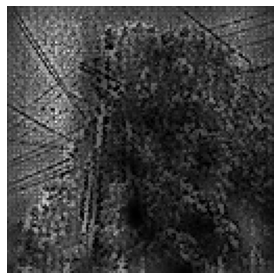

In [17]:
renderGGCAM(18, False, False, True)

Observed image class:  Improbable
Class labels:  ['Probable/Possible', 'Improbable']
Loss output:  tf.Tensor([[-2.5035484  3.0303414]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=3.0303414>]
Probability of prediction:  ['1.0']
Predicted class:  ['Improbable']
[array([0.00393505, 0.99606496], dtype=float32)]
Shape of heatmap matrix: (128, 128)


array([[[  2, 232, 244],
        [  5, 236, 241],
        [ 15, 248, 231],
        ...,
        [  0, 208, 255],
        [  0, 192, 255],
        [  0, 188, 255]],

       [[  2, 232, 244],
        [  5, 236, 241],
        [ 18, 252, 228],
        ...,
        [  0, 212, 255],
        [  0, 196, 255],
        [  0, 192, 255]],

       [[  2, 232, 244],
        [  8, 240, 237],
        [ 18, 252, 228],
        ...,
        [  0, 224, 250],
        [  0, 212, 255],
        [  0, 204, 255]],

       ...,

       [[  0, 180, 255],
        [  0, 184, 255],
        [  0, 196, 255],
        ...,
        [  0, 184, 255],
        [  0, 180, 255],
        [  0, 176, 255]],

       [[  0, 160, 255],
        [  0, 168, 255],
        [  0, 180, 255],
        ...,
        [  0, 192, 255],
        [  0, 188, 255],
        [  0, 184, 255]],

       [[  0, 156, 255],
        [  0, 160, 255],
        [  0, 176, 255],
        ...,
        [  0, 196, 255],
        [  0, 188, 255],
        [  0, 188, 255]]

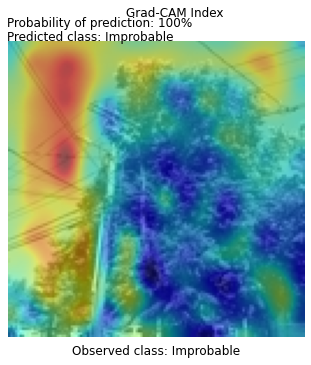

In [18]:
renderGradCam(18)

(128, 128)


<tf.Tensor: shape=(128, 128, 1), dtype=float32, numpy=
array([[[-0.02458302],
        [ 0.10416356],
        [ 0.01110504],
        ...,
        [ 0.09537458],
        [ 0.1186945 ],
        [ 0.06478044]],

       [[ 0.02762825],
        [ 0.09611331],
        [ 0.13624732],
        ...,
        [ 0.12201051],
        [ 0.04881015],
        [ 0.04512375]],

       [[-0.02631072],
        [ 0.09816582],
        [ 0.12459537],
        ...,
        [-0.02891614],
        [ 0.12357381],
        [-0.01700903]],

       ...,

       [[ 0.00234273],
        [-0.20110174],
        [-0.14608517],
        ...,
        [ 0.32886425],
        [ 0.15434527],
        [ 0.03630316]],

       [[-0.03108577],
        [ 0.07313263],
        [-0.01017673],
        ...,
        [ 0.03858628],
        [ 0.20107427],
        [ 0.09912805]],

       [[ 0.03388277],
        [ 0.11198416],
        [-0.10534415],
        ...,
        [ 0.09079113],
        [ 0.1688181 ],
        [ 0.13809083]]], dtype=float32)

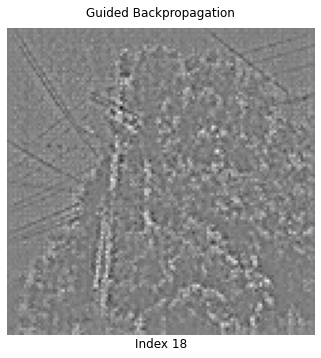

In [19]:
renderGBP(18)

(128, 128)


<tf.Tensor: shape=(128, 128, 1), dtype=float32, numpy=
array([[[-0.02458302],
        [ 0.10416356],
        [ 0.01110504],
        ...,
        [ 0.09537458],
        [ 0.1186945 ],
        [ 0.06478044]],

       [[ 0.02762825],
        [ 0.09611331],
        [ 0.13624732],
        ...,
        [ 0.12201051],
        [ 0.04881015],
        [ 0.04512375]],

       [[-0.02631072],
        [ 0.09816582],
        [ 0.12459537],
        ...,
        [-0.02891614],
        [ 0.12357381],
        [-0.01700903]],

       ...,

       [[ 0.00234273],
        [-0.20110174],
        [-0.14608517],
        ...,
        [ 0.32886425],
        [ 0.15434527],
        [ 0.03630316]],

       [[-0.03108577],
        [ 0.07313263],
        [-0.01017673],
        ...,
        [ 0.03858628],
        [ 0.20107427],
        [ 0.09912805]],

       [[ 0.03388277],
        [ 0.11198416],
        [-0.10534415],
        ...,
        [ 0.09079113],
        [ 0.1688181 ],
        [ 0.13809083]]], dtype=float32)

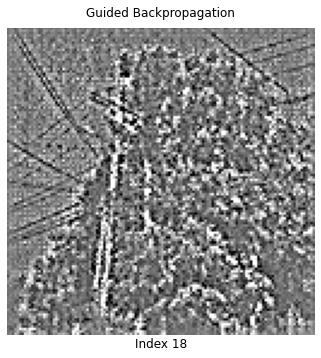

In [20]:
renderGBP(18, True)

Observed image class:  Improbable
Class labels:  ['Probable/Possible', 'Improbable']
Loss output:  tf.Tensor([[-2.5035484  3.0303414]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=3.0303414>]
Probability of prediction:  ['1.0']
Predicted class:  ['Improbable']
[array([0.00393505, 0.99606496], dtype=float32)]
Shape of heatmap matrix: (128, 128)
Shape of GGCAM:  (128, 128)
Observed image class:  Improbable
Class labels:  ['Probable/Possible', 'Improbable']
Loss output:  tf.Tensor([[-2.5035484  3.0303414]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=3.0303414>]
Probability of prediction:  ['1.0']
Predicted class:  ['Improbable']
[array([0.00393505, 0.99606496], dtype=float32)]
Shape of heatmap matrix: (128, 128)
Shape of GGCAM:  (128, 128)


array([[-0.00866167,  0.03720238,  0.00411439, ...,  0.03144671,
         0.03730033,  0.01999352],
       [ 0.00974808,  0.03439009,  0.05062984, ...,  0.04077877,
         0.01558008,  0.01415719],
       [-0.00932311,  0.03531703,  0.04669345, ..., -0.01001487,
         0.04108611, -0.00556982],
       ...,
       [ 0.00070843, -0.06169719, -0.04656448, ...,  0.10092246,
         0.04651401,  0.01086459],
       [-0.00883859,  0.02118685, -0.00309681, ...,  0.01211645,
         0.06222541,  0.03050517],
       [ 0.00940627,  0.03173039, -0.03148987, ...,  0.02875044,
         0.052751  ,  0.04292861]], dtype=float32)

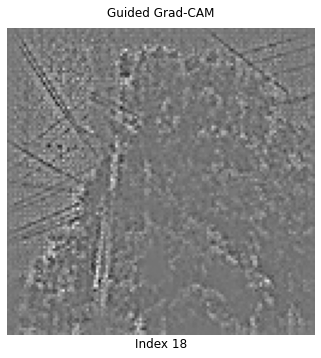

In [21]:
renderGGCAM(18)

Observed image class:  Improbable
Class labels:  ['Probable/Possible', 'Improbable']
Loss output:  tf.Tensor([[-2.5035484  3.0303414]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=3.0303414>]
Probability of prediction:  ['1.0']
Predicted class:  ['Improbable']
[array([0.00393505, 0.99606496], dtype=float32)]
Shape of heatmap matrix: (128, 128)
Shape of GGCAM:  (128, 128)


array([[38.405453, 48.21573 , 42.977715, ..., 43.85248 , 43.367176,
        39.196674],
       [41.986786, 47.588436, 52.39594 , ..., 46.122837, 39.58051 ,
        38.590202],
       [38.269398, 48.20907 , 52.091743, ..., 37.40493 , 46.215054,
        36.02087 ],
       ...,
       [34.47299 , 22.396103, 26.774902, ..., 55.238728, 43.69769 ,
        36.212143],
       [30.70755 , 37.082172, 34.081955, ..., 38.30914 , 47.657578,
        41.236485],
       [33.591057, 38.535213, 27.79991 , ..., 41.799877, 46.245914,
        44.14386 ]], dtype=float32)

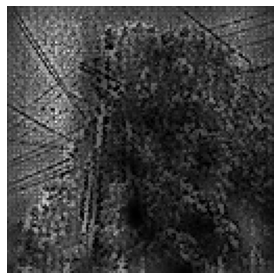

In [22]:
renderGGCAM(18, True, False, 'jet')

In [23]:
def plotVisualizations(index, save=False):
    subplot_args = { 'nrows': 1, 'ncols': 4, 'figsize': (15, 15), 
                    'subplot_kw': {'xticks': [], 'yticks': []} }
    grid_dir = '../../figures/'
    plot_name = 'plot_grid_'+str(index)
    f, axs = plt.subplots(**subplot_args)
    f.set_facecolor("white")
    axis_labels = ['Processed Input', 'GradCAM', 'Guided Backprop', 'Guided GradCAM']
    orig_image = validation_images[index]
    gcam_heatmap = renderGradCam(index, False, True)    
    gbp = renderGBP(index, False, False, True)
    ggcam = renderGGCAM(index, False, False, True)
    f.suptitle('Observed: ' + class_labels[np.argmax(validation_labels[index])]+ '. Predicted: ' + str(grad_cam([index])[3])[2:-2]+'. Probability: '+str("{:.0%}".format(float(str(grad_cam([index])[2])[2:-2])))+'.', y=0.595, fontsize=24, va='bottom') 
    axs[0].imshow(np.squeeze(orig_image), cmap='gist_gray')
    axs[1].imshow(np.squeeze(orig_image), cmap='gist_gray')
    axs[1].imshow(gcam_heatmap, cmap = 'jet', alpha=0.5)
    axs[2].imshow(np.squeeze(gbp), cmap='jet')
    axs[3].imshow(ggcam)
    for axis in f.axes:
        axis.set_axis_on()
        axis.set_xticks([])
        axis.set_yticks([])
        axis.spines["top"].set_visible(False)
        axis.spines["right"].set_visible(False)
        axis.spines["left"].set_visible(False)
        axis.spines["bottom"].set_visible(False)        
    for i, axis in enumerate(f.axes):
        axis.set_xlabel(axis_labels[i], fontsize=18)
    f.tight_layout(rect=[0, 0, 1, 0.95])
    if save:
        f.savefig(grid_dir+plot_name, bbox_inches='tight')
        print('Saving '+plot_name+' in '+grid_dir)
    return 

Observed image class:  Improbable
Class labels:  ['Probable/Possible', 'Improbable']
Loss output:  tf.Tensor([[-4.5054197  2.6816638]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=2.6816638>]
Probability of prediction:  ['1.0']
Predicted class:  ['Improbable']
[array([7.5572007e-04, 9.9924433e-01], dtype=float32)]
Shape of heatmap matrix: (128, 128)
(128, 128)
Observed image class:  Improbable
Class labels:  ['Probable/Possible', 'Improbable']
Loss output:  tf.Tensor([[-4.5054197  2.6816638]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=2.6816638>]
Probability of prediction:  ['1.0']
Predicted class:  ['Improbable']
[array([7.5572007e-04, 9.9924433e-01], dtype=float32)]
Shape of heatmap matrix: (128, 128)
Shape of GGCAM:  (128, 128)
Observed image class:  Improbable
Class labels:  ['Probable/Possible', 'Improbable']
Loss output:  tf.Tensor([[-4.5054197  2.6816638]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float

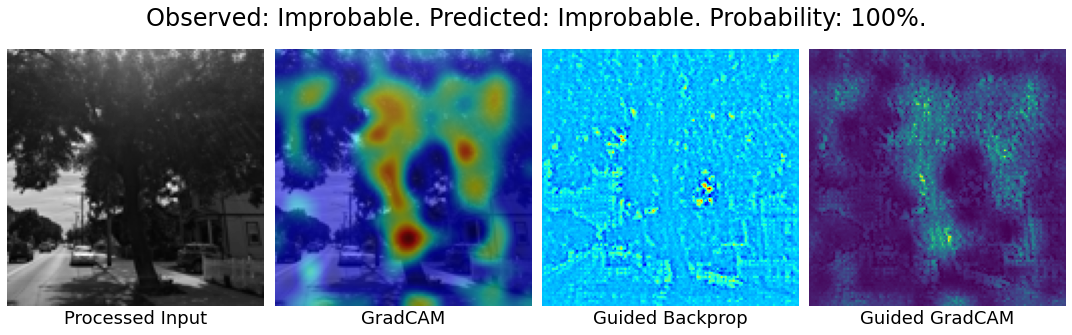

In [27]:
plotVisualizations(107, True)